<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
3. [Regression Benchmarking](#3-benchmarking)
4. [Model Optimization - Ensemble & Stacking](#4-optimization)
5. [Deployment - Final Submission](#5-deployment)


---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

### 1.1 Import Libraries

In [61]:
# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer
)

# Custom utilities
import utils

# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Local - Custom preprocessing pipeline
from preprocessing_pipeline import CarPreprocessingPipeline

# Plot style
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

### 1.2 Load Data

In [62]:
# Load dictionary for brand/model cleaning
brand_model_dic = pd.read_parquet("./project_data/brand_model_dic.parquet", engine="pyarrow")

# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,763 rows, 39 features
Val:   15,193 rows
Test:  32,567 rows


In [64]:
# Prepare target arrays and combined datasets
all_features = list(X_train_scaled.columns)

# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,763
Val samples:   15,193
Full samples:  75,956


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

### 2.1 Business Based

In [66]:
X_train_scaled = X_train_scaled.drop(columns='paintQuality%', errors='ignore')
X_val_scaled =X_val_scaled.drop(columns='paintQuality%', errors='ignore')
X_test_scaled = X_test_scaled.drop(columns='paintQuality%', errors='ignore')

### 2.2 Variance Threshold

In [ ]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_scaled)

# Get low variance columns and print them
low_variance = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from train, val and test sets
#X_train_scaled = X_train_scaled.drop(columns=low_variance, errors='ignore')
#X_val_scaled = X_val_scaled.drop(columns=low_variance, errors='ignore')
#X_test_scaled = X_test_scaled.drop(columns=low_variance, errors='ignore')

Number of features with variance closer to zero: 5
Features with variance closer to zero:
hasDamage: 0.0000
age: 0.0000
age_squared: 0.0000
is_new_car: 0.0000
is_old_car: 0.0000


In [71]:
# Drop low variance columns from train, val and test sets
X_train_scaled = X_train_scaled.drop(columns='hasDamage', errors='ignore')
X_val_scaled = X_val_scaled.drop(columns='hasDamage', errors='ignore')
X_test_scaled = X_test_scaled.drop(columns='hasDamage', errors='ignore')

### 2.3 Correlation Indices with price

In [70]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([X_train_scaled, y_train], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_18628\264488923.py:17: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")


=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,brand_model_target_enc,0.777850,0.777850
1,age,-0.590011,0.590011
2,age_squared,-0.590011,0.590011
3,Brand_target_enc,0.580219,0.580219
4,transmission_manual,-0.579835,0.579835
5,engineSize,0.562352,0.562352
6,brand_price_std,0.547286,0.547286
7,brand_segment_luxury,0.534849,0.534849
8,miles_per_year,-0.508972,0.508972
9,mileage,-0.508935,0.508935


\ Features with |corr| < 0.1 (14):


,Feature,Correlation,Abs_Correlation
21,fuelType_hybrid,0.073975,0.073975
22,mpg_is_missing,0.051698,0.051698
23,tax_is_missing,0.050209,0.050209
24,brand_segment_mid_range,-0.046736,0.046736
25,Brand_freq_enc,-0.015477,0.015477
26,mpg_per_liter,0.014818,0.014818
27,fuelType_other,0.007272,0.007272
28,engineSize_is_missing,-0.004617,0.004617
29,transmission_other,0.004114,0.004114
30,year_is_missing,0.003742,0.003742


In [75]:
drop_features = ['mpg_is_missing', 'tax_is_missing', 'fuelTyoe_other', 'engineSize_is_missing', 'transmission_other', 'year_is_missing', 
                 'transmission_unknown', 'fuelType_unknown']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.4 Statistical Hypothesis Testing - ANOVA

In [81]:
bin_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dropna().nunique() == 2]

X_train_cat = X_train_scaled
for c in bin_cols:
    X_train_cat[c] = X_train_scaled[c].astype('category')

alpha = 0.01

ANOVA_COLS = X_train_cat.columns.tolist() 

anova_results = []
y_price = y_price = y_train['price'].copy()

for col in ANOVA_COLS:
    # Prepare data for ANOVA test
    temp_df = pd.DataFrame({'category': X_train_cat[col], 'price': y_price}).dropna()
    
    # Get price lists for each category
    # If the column has few categories, use all
    groups = [temp_df['price'][temp_df['category'] == category] 
              for category in temp_df['category'].unique()]
    
    # Execute the ANOVA Test
    if len(groups) > 1 and all(len(g) > 0 for g in groups):
        f_stat, p_value = f_oneway(*groups)
        
        #if p < alpha, reject H0 (group means are different) which means the variable is PREDICTIVE
        decision = "predictive" if p_value < alpha else "NOT predictive"
        
        # Calculate mean prices per category
        mean_prices = temp_df.groupby('category')['price'].mean().round(2).to_dict()
    else:
        f_stat, p_value = np.nan, np.nan
        decision = "single group"
        mean_prices = {}

    anova_results.append({
        "Variable": col,
        "Test": "ANOVA",
        "F_Stat": f_stat,
        "p_value": p_value,
        "Decision": decision,
        "Group_Means": mean_prices
    })

# Convert to DataFrame for easy visualization
df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_18628\1564763640.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = temp_df.groupby('category')['price'].mean().round(2).to_dict()


,Variable,Test,F_Stat,p_value,Decision,Group_Means
0,tax,ANOVA,2.814569,0.000000e+00,predictive,"{-2.0041098150450583: 30494.0, -1.903384788643..."
1,mpg,ANOVA,7.227783,0.000000e+00,predictive,"{-8.20743813387326: 28990.0, -6.52939963481952..."
2,engineSize,ANOVA,42.531365,0.000000e+00,predictive,"{-10.08304154027602: 19490.0, -10.028707353685..."
3,brand_price_std,ANOVA,2772.670693,0.000000e+00,predictive,"{-1.5393554638923395: 10378.53, -0.91854517618..."
4,age_squared,ANOVA,2695.708209,0.000000e+00,predictive,"{-2.220446049250313e-16: 24067.54, 0.0: 14703...."
5,age,ANOVA,2695.708209,0.000000e+00,predictive,"{-1.2756462552943049e-13: 24067.54, 1.47104550..."
6,low_mileage,ANOVA,13882.805441,0.000000e+00,predictive,"{-0.577356603639529: 14450.42, 1.7320318044276..."
7,high_mileage,ANOVA,6023.465580,0.000000e+00,predictive,"{-0.5773312658399115: 18562.09, 1.732107819494..."
8,mpg_per_liter,ANOVA,17.989575,0.000000e+00,predictive,"{-47.6098069532665: 15750.0, -14.3525477637270..."
9,model_popularity,ANOVA,483.630514,0.000000e+00,predictive,"{-3.234386187931603: 5909.14, -3.1196100747646..."


In [82]:
drop_features = ['fuelType_other', 'previousOwners', 'fuelType_electric']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.2 Calculate Feature Importance per Model

In [83]:
# Gradient Boosting - Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_array)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# Random Forest - Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_array)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# KNN - Correlation-based importance (since KNN has no native feature importance)
knn_importance = pd.Series({
    feat: np.abs(np.corrcoef(X_train_scaled[feat], y_train_array)[0, 1])
    for feat in X_train_scaled.columns
}).sort_values(ascending=False)

# Display importance rankings
print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKINGS")
print("="*70)

for name, imp in [('Gradient Boosting', gb_importance), ('Random Forest', rf_importance), ('KNN (Correlation)', knn_importance)]:
    print(f"\n{name} - Top 10:")
    print(imp.head(10).to_string())


FEATURE IMPORTANCE RANKINGS

Gradient Boosting - Top 10:
brand_model_target_enc                   0.474490
age                                      0.087180
engineSize                               0.086574
mpg                                      0.082689
miles_per_year                           0.067229
transmission_manual                      0.048291
premium_brand_engine_size_interaction    0.046230
age_squared                              0.035805
age_mileage_interaction                  0.033893
mileage                                  0.008250

Random Forest - Top 10:
brand_model_target_enc                   0.510101
engineSize                               0.123815
miles_per_year                           0.071928
age_squared                              0.069115
age                                      0.054823
mpg                                      0.039087
premium_brand_engine_size_interaction    0.033790
age_mileage_interaction                  0.026692
mileage          

c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


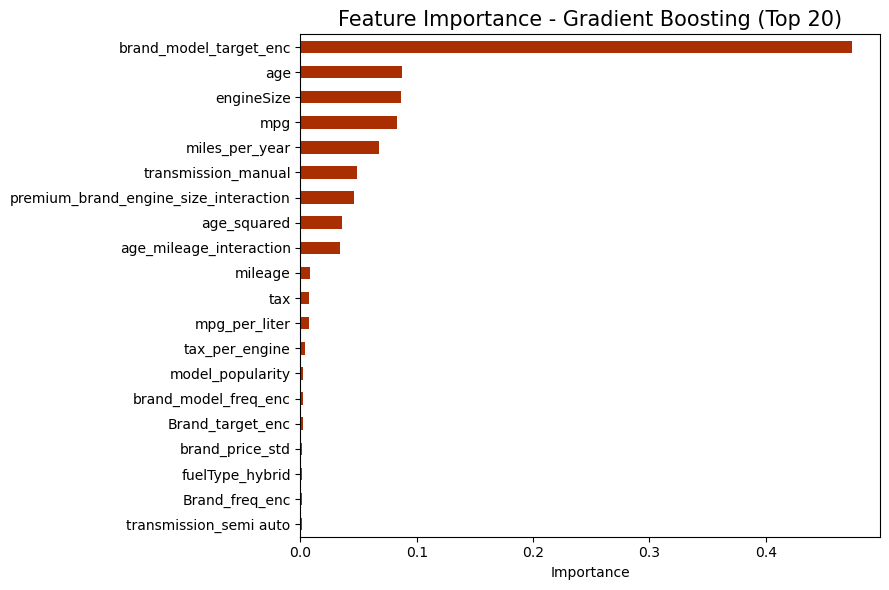

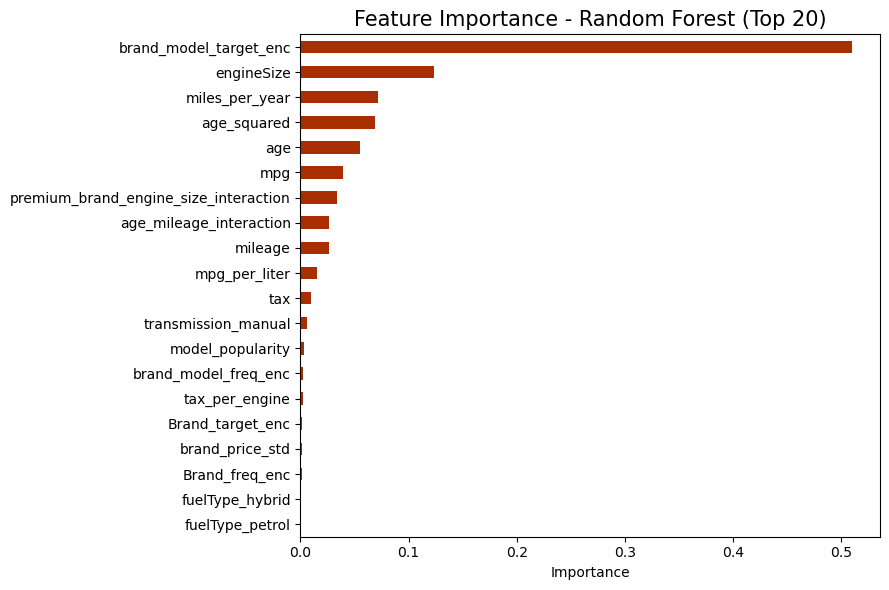

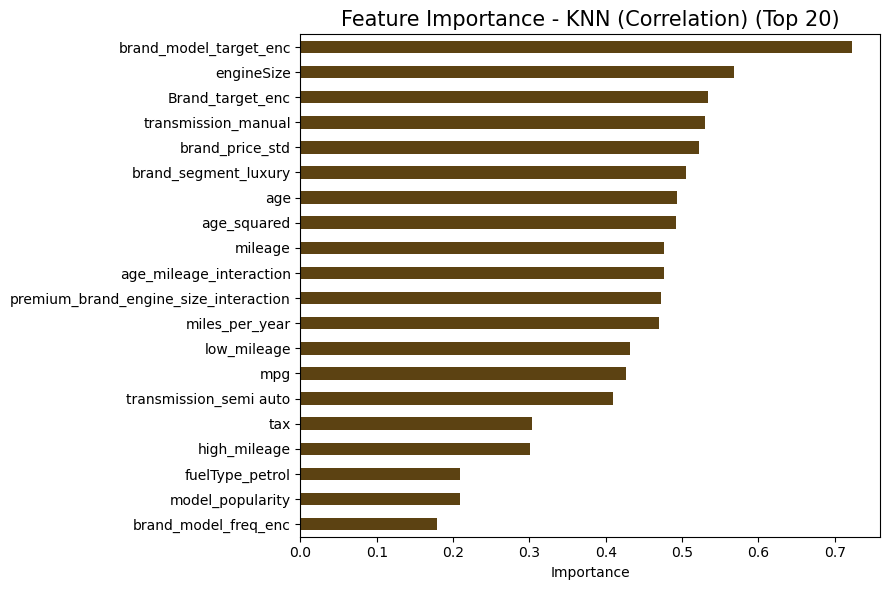

In [84]:
# Plot feature importance
utils.plot_importance_unified(palette, gb_importance, "Gradient Boosting", is_tree_model=True)
utils.plot_importance_unified(palette, rf_importance, "Random Forest", is_tree_model=True)
utils.plot_importance_unified(palette, knn_importance, "KNN (Correlation)", is_tree_model=False)

### 2.3 Select Optimal Number of Features

We test different numbers of top features (8-15) to find the optimal subset for each model.

In [85]:
# Store best results per model (no initial assumptions)
best_results = {
    'GB':  {'features': gb_importance.index.tolist(),  'best_n': None, 'best_mae': float('inf')},
    'RF':  {'features': rf_importance.index.tolist(),  'best_n': None, 'best_mae': float('inf')},
    'KNN': {'features': knn_importance.index.tolist(), 'best_n': None, 'best_mae': float('inf')}
}

# Model configurations
model_configs = {
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
}

# Feature importance rankings per model
importance_rankings = {
    'GB': gb_importance,
    'RF': rf_importance,
    'KNN': knn_importance
}

# Test range: from 3 features up to all available
max_features = len(X_train_scaled.columns)
feature_range = range(3, 20)  # Test 3 to 41 features

print("\nTesting different numbers of features...\n")

for n_features in feature_range:
    print(f"{'='*70}")
    print(f"Testing {n_features} features:")
    print(f"{'='*70}\n")
    
    for model_name, create_model in model_configs.items():
        # Get top N features for this model
        features = importance_rankings[model_name].index[:n_features].tolist()
        
        # Train and evaluate
        model = create_model()
        model.fit(X_train_scaled[features], y_train_array)
        val_mae = mean_absolute_error(y_val_array, model.predict(X_val_scaled[features]))
        
        print(f"   {model_name} (top {n_features}): VAL MAE: £{val_mae:,.2f}")
        
        # Update best if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features
    
    print()

# Summary
print("\n" + "="*70)
print("BEST NUMBER OF FEATURES PER MODEL")
print("="*70)
for model_name, results in best_results.items():
    print(f"   {model_name}: {results['best_n']} features → VAL MAE: £{results['best_mae']:,.2f}")
    print(f"        Features: {results['features'][:results['best_n']]}")


Testing different numbers of features...

Testing 3 features:

   GB (top 3): VAL MAE: £2,081.82
   RF (top 3): VAL MAE: £1,992.05
   KNN (top 3): VAL MAE: £3,568.54

Testing 4 features:

   GB (top 4): VAL MAE: £1,815.99
   RF (top 4): VAL MAE: £1,711.85
   KNN (top 4): VAL MAE: £3,382.09

Testing 5 features:

   GB (top 5): VAL MAE: £1,564.11
   RF (top 5): VAL MAE: £1,710.94
   KNN (top 5): VAL MAE: £3,367.43

Testing 6 features:

   GB (top 6): VAL MAE: £1,519.00
   RF (top 6): VAL MAE: £1,490.56
   KNN (top 6): VAL MAE: £3,368.79

Testing 7 features:

   GB (top 7): VAL MAE: £1,527.66
   RF (top 7): VAL MAE: £1,481.10
   KNN (top 7): VAL MAE: £2,057.37

Testing 8 features:

   GB (top 8): VAL MAE: £1,527.38
   RF (top 8): VAL MAE: £1,482.20
   KNN (top 8): VAL MAE: £2,057.37

Testing 9 features:

   GB (top 9): VAL MAE: £1,519.29
   RF (top 9): VAL MAE: £1,484.72
   KNN (top 9): VAL MAE: £1,917.28

Testing 10 features:

   GB (top 10): VAL MAE: £1,521.08
   RF (top 10): VAL MAE: 

<a id='3-benchmarking'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

We use a **holdout validation strategy** (80/20 split) to evaluate models. The primary metric is **Mean Absolute Error (MAE)** as it directly represents the average prediction error in pounds.

### 3.1 Evaluation Function

In [86]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Calculate train and validation metrics"""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

### 3.2 Hyperparameter Grid Search

In [87]:
# Define model configurations with hyperparameter grids
# Using model-specific feature subsets and scaling

models_and_grids = {
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37),
        "params": {
            'learning_rate': [0.06, 0.07, 0.08, 0.09],
            'max_depth': [7, 9, 11],
            'min_samples_leaf': [2, 3],
            'n_estimators': [500, 700],
            'subsample': [0.8, 0.9, 1.0]
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['GB']['features'][:best_results['GB']['best_n']]
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100, 130, 150],
            'max_depth': [15, 20, 25],
            'min_samples_leaf': [2, 3],
            'max_features': [0.6, 0.7, 0.8]
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['RF']['features'][:best_results['RF']['best_n']]
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [7, 10, 12, 15],
            'weights': ['uniform', 'distance']
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['KNN']['features'][:best_results['KNN']['best_n']]
    }
}

In [ ]:
# Run grid search for each model
results_list = []

for model_name, config in models_and_grids.items():
    print(f"\n{'='*70}")
    print(f"Grid Search: {model_name}")
    print(f"{'='*70}")
    
    X_tr = config['X_train'][config['features']]
    X_vl = config['X_val'][config['features']]
    
    param_grid = ParameterGrid(config['params'])
    best_val_mae = float('inf')
    best_result = None
    
    for i, params in enumerate(param_grid):
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_array)
        
        scores = evaluate_model(model, X_tr, y_train_array, X_vl, y_val_array)
        
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores
            }
            print(f"   New best: {params} → VAL MAE: £{scores['Val MAE']:,.2f}")
    
    results_list.append(best_result)
    print(f"\n✅ Best {model_name} VAL MAE: £{best_val_mae:,.2f}")

# Create results DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
display(results_df[['Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Best Params']])


Grid Search: GradientBoosting


<a id='4-optimization'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Model Optimization - Stacking Ensemble</b></span>
    </h1>
</div>

We use **Stacking** to combine our three best models (GB, RF, KNN). Stacking trains a meta-learner (Ridge regression) on the predictions of base models, learning optimal combination weights automatically via cross-validation.

Additionally, we apply **log transformation** to the target variable, which reduces the impact of price outliers and typically improves MAE in price prediction tasks.

### 4.1 Extract Best Parameters

In [ ]:
# Extract best hyperparameters from grid search
best_params = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params[model_name] = eval(params_str)
    print(f"{model_name}: {best_params[model_name]}")

### 4.2 Train Stacking Model

In [ ]:
# Define feature subsets for stacking
gb_features  = best_results['GB']['features'][:best_results['GB']['best_n']]
rf_features  = best_results['RF']['features'][:best_results['RF']['best_n']]
knn_features = best_results['KNN']['features'][:best_results['KNN']['best_n']]

# Union of all features (stacking uses all)
all_features = list(set(gb_features + rf_features + knn_features))
print(f"Features for stacking: {len(all_features)}")

# Create stacking model
stacking_model = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train with LOG-transformed target
print("Training stacking model with log(price)...", end=" ", flush=True)
stacking_model.fit(X_train_scaled[all_features], y_train_log)
print("✅")

# Evaluate on validation (convert predictions back to original scale)
stacking_train_pred_log = stacking_model.predict(X_train_scaled[all_features])
stacking_train_pred = np.expm1(stacking_train_pred_log)  # exp(x) - 1 to invert log1p
stacking_train_mae = mean_absolute_error(y_val_array, stacking_train_pred)

# Evaluate on validation (convert predictions back to original scale)
stacking_val_pred_log = stacking_model.predict(X_val_scaled[all_features])
stacking_val_pred = np.expm1(stacking_val_pred_log)  # exp(x) - 1 to invert log1p
stacking_val_mae = mean_absolute_error(y_val_array, stacking_val_pred)

print(f"\n✅ Stacking TRAIN MAE: £{stacking_train_mae:,.2f}")
print(f"\n✅ Stacking VAL MAE: £{stacking_val_mae:,.2f}")

# Compare with individual models
print("\nComparison with individual models:")
for _, row in results_df.iterrows():
    print(f"   {row['Model']}: £{row['Val MAE']:,.2f}")
print(f"   Stacking: £{stacking_val_mae:,.2f}")

<a id='5-deployment'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>5 | Deployment - Final Submission</b></span>
    </h1>
</div>

Retrain the stacking model on the full dataset (train + validation) and generate predictions for the test set.

In [ ]:
# Retrain stacking on full data (train + validation)
print(f"Full training set: {len(y_train_full_array):,} samples")
print(f"Features: {len(all_features)}")

stacking_model_final = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

print("\nTraining final stacking model on full data...", end=" ", flush=True)
stacking_model_final.fit(X_train_full_scaled[all_features], y_train_full_log)
print("✅")

In [ ]:
# Generate predictions for test set
test_pred_log = stacking_model_final.predict(X_test_scaled[all_features])
test_pred = np.expm1(test_pred_log)  # Convert back to original scale

# Create submission DataFrame
submission_df = pd.DataFrame({
    'carID': X_test_scaled.index,
    'price': test_pred
})

# Save submission
submission_filename = "./project_data/Group37_Stacking_Final.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"\n" + "="*70)
print("SUBMISSION GENERATED")
print("="*70)
print(f"\n✅ Saved: {submission_filename}")
print(f"   Rows: {len(submission_df):,}")
print(f"   Price range: £{submission_df['price'].min():,.2f} - £{submission_df['price'].max():,.2f}")
print(f"   Mean price: £{submission_df['price'].mean():,.2f}")

print("\nFirst 5 predictions:")
display(submission_df.head())

---
## Summary

**Final Model:** Stacking Ensemble (GradientBoosting + RandomForest + KNeighbors) with Ridge meta-learner

**Key Optimizations:**
1. Model-specific feature selection based on importance rankings
2. Model-specific scaling (scaled for KNN, unscaled for tree models)
3. Log transformation of target to reduce outlier impact
4. Stacking with 5-fold CV for optimal weight learning

**Validation MAE:** See results above

---